# Evenements culturels : Création d'une carte interactive

Durant ce projet, nous allons utiliser la base de données répertoriant les évènements culturels en île de France (https://data.iledefrance.fr/explore/dataset/evenements-publics-cibul/table/) pour extraire les différents évènements et récupérer les informations importantes comme la date, le prix, ou le sujet et les mettre sous des formes faciles à utiliser.

Tout d'abord, nous allons import le dataframe et récupérer les informations que nous pouvons principalement grâce à des expressions régulières et à du web scraping. Ensuite, pour obtenir le sujet des évènements nous allons utiliser du NLP en trouvant les termes revenant le plus souvent. Finalement, nous finirons par analyser les données trouvées.

from datetime import time## Installations et imports de modules

In [115]:
# Trivia
import pandas as pd
import numpy as np
from collections import Counter

# Regex
import re

# API, data import
import urllib
import bs4
from urllib import request
import requests

# User informations
import sys
!{sys.executable} -m pip install geopy
import geopy
from geopy.geocoders import Nominatim
from geopy import distance
import datetime as dt
!pip install pandas fiona shapely pyproj rtree
!pip install pygeos
!pip install geopandas
!pip install contextily
import pygeos
import rtree
import pandas as pd
import contextily as ctx
import geopandas as gdp

# Plotting
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.patches import Ellipse
import base64
import string
import re
!pip install folium
import folium

from shapely.geometry import Point

# Natural Language Processing
!pip install nltk
import nltk
from nltk.corpus import stopwords
from time import time
#from sklearn.feature_extraction.stop_words import ENGLISH_STOP_WORDS as stopwords
from sklearn.metrics import log_loss
import matplotlib.pyplot as plt
!pip install pywaffle
from pywaffle import Waffle
from nltk.stem import WordNetLemmatizer
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.decomposition import NMF, LatentDirichletAllocation

nltk.download('punkt')
nltk.download('stopwords')
stop_words = set(stopwords.words('french'))

!pip install spacy
!pip install https://github.com/explosion/spacy-models/releases/download/fr_core_news_sm-3.1.0/fr_core_news_sm-3.1.0.tar.gz

import spacy

nlp = spacy.load("fr_core_news_sm")

     |████████████████████████████████| 95 kB 1.6 MB/s            


[nltk_data] Downloading package punkt to /home/jovyan/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /home/jovyan/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


     |████████████████████████████████| 17.1 MB 2.0 MB/s            
  Preparing metadata (setup.py) ... done


## Données : Collecte et Nettoyage

In [224]:
class User:
    ''' The User Class allows us to store every piece of information about the User '''
    
    def __init__(self, address, date, price_max = 42, distance_max = 20, favourite_tag = "théâtre"):
        geolocator = Nominatim(user_agent="CulturalEvents")
        location = geolocator.geocode(address)
        self.latlon = (location.latitude, location.longitude)
        self.date = date
        self.price_max = price_max
        self.distance_max = distance_max
        self.favourite_tag = favourite_tag
        
Naclanga = User("27 Boulevard Thomas Gobert, Palaiseau", dt.date.today())

In [3]:
# Query to extract a specific frame of time, the user desired date
query = "date_start < " + str(Naclanga.date + dt.timedelta(days=7)) + " AND date_start > "  + str(Naclanga.date)

# Request. We can extract up to 1000 rows but it can be time consuming, that's why we restrict the timeframe
url = "https://data.iledefrance.fr/api/records/1.0/search/?dataset=evenements-publics-cibul&q=&rows=1000&q=(" + query + ")&sort=date_start"
req = requests.get(url)
df = pd.json_normalize(req.json()['records'])

# Rename the columns
important_keys = ["fields.title", "fields.latlon", "fields.date_start", "fields.tags", "fields.pricing_info", "fields.description",'fields.link', 'fields.free_text', 'fields.address', 'fields.department','fields.placename', 'fields.region', 'fields.date_end', 'fields.lang', 'geometry.type', 'geometry.coordinates', 'fields.city_district']
df = df[important_keys]
dict_important_keys = {elt : elt.replace("fields.", "") for elt in important_keys}
df.rename(columns = dict_important_keys, inplace=True)

df_to_treat = df.copy()
df_to_treat

,title,latlon,date_start,tags,pricing_info,description,link,free_text,address,department,placename,region,date_end,lang,geometry.type,geometry.coordinates,city_district
0,Spectacle : Qui est Monsieur Schmitt ?,"[48.822957, 2.269862]",2022-01-12,"Stéphane De Groodt,Valérie Bonneton,Sébastien ...",https://www.palaisdescongresdissy.com/fr/site/...,Stéphane De Groodt et Valérie Bonneton dans la...,http://openagenda.com/event/spectacle-qui-est-...,M. et Mme Bélier dînent tranquillement dans le...,"25 avenue Victor Cresson, 92130 Issy-les-Mouli...",Hauts-de-Seine,Palais des Congrès d'Issy,Île-de-France,2022-01-12,fr,Point,"[2.269862, 48.822957]",NaN
1,Tous en scène 2,"[48.8258, 2.269464]",2022-01-12,NaN,NaN,Retrouvez ces animaux artistes dans leur nouve...,http://openagenda.com/event/tous-en-scene-2-37...,Si Buster et sa troupe ont fait du Nouveau Thé...,"11-13, rue Danton 92130 Issy-les-Moulineaux",Hauts-de-Seine,Ciné d'Issy,Île-de-France,2022-01-12,fr,Point,"[2.269464, 48.8258]",NaN
2,Cycle de formation sur le Missel et l’Eucharistie,"[48.882801, 2.312324]",2022-01-12,NaN,NaN,A l’occasion de la mise en vigueur de la nouve...,http://openagenda.com/event/cycle-de-formation...,Prochaine rencontre le mercredi 12 janvier à 2...,"22 bis rue Legendre, 75017 Paris",Paris,Église Saint-Charles de Monceau,Île-de-France,2022-01-12,fr,Point,"[2.312324, 48.882801]",NaN
3,Cartographie sensible de Versailles,"[48.803948, 2.134068]",2022-01-12,NaN,Sur réservation,"Durant ces 4 ateliers, les enfants écriront pu...",http://openagenda.com/event/cartographie-sensi...,NaN,8 rue Saint-Simon 78000 Versailles,Yvelines,Atelier Numérique,Île-de-France,2022-02-02,fr,Point,"[2.134068, 48.803948]",Montreuil
4,Conté-Partagé,"[48.833004, 2.313716]",2022-01-12,NaN,NaN,Une séance de contes du monde pour les enfants...,http://openagenda.com/event/conte-partage,NaN,23 bis rue du Moulin de la Vierge,Paris,le moulin de la vierge,Île-de-France,2022-01-12,fr,Point,"[2.313716, 48.833004]",NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
175,JOULE - installation vidéo,"[48.787452, 2.044525]",2022-01-07,NaN,Entrée libre,JOULE est un projet chorégraphique consacré à ...,http://openagenda.com/event/joule-installation...,JOULE est un **projet chorégraphique consacré ...,Saint-Quentin-en-Yvelines,Yvelines,"Théâtre,scène nationale de Saint-Quentin-en-Yv...",Île-de-France,2022-02-19,fr,Point,"[2.044525, 48.787452]",NaN
176,JOSEF JOSEF,"[48.875921, 2.097268]",2022-01-07,Concert,Plein tarif 25€ / Tarif réduit 16€,Concert,http://openagenda.com/event/josef-josef,### **Vendredi 7 janvier**\n\n### **à 20h30**\...,44 allée des épines 78160,Yvelines,Centre culturel Jean Vilar,Île-de-France,2022-01-07,fr,Point,"[2.097268, 48.875921]",NaN
177,Vive le Sport,"[48.890801, 2.375054]",2022-01-07,NaN,NaN,Atelier chansons avec l'association Mélodix,http://openagenda.com/event/vive-le-sport,NaN,"15 rue Mathis, 75019",Paris,Centre Paris Anim'Mathis,Île-de-France,2022-01-08,fr,Point,"[2.375054, 48.890801]",NaN
178,Théâtre - L'Avare,"[49.087273, 2.505562]",2022-01-07,"théâtre,l'avare,molière","9€ / 5,50€ / 2,80€",L'Avare de Molière / Mise en scène de Tigran M...,http://openagenda.com/event/theatre-lavare,**L'Avare**\n**Compagnie de L'Illustre Théâtre...,rue marcel petit 95670 Marly-la-Ville,Val-d'Oise,Espace Culturel Lucien Jean,Île-de-France,2022-01-07,fr,Point,"[2.505562, 49.087273]",Le Clos Maillard


### Calcul de la distance

Grâce aux informations contenues dans le tableau et celles fournies par l'utilisateur. On peut calculer la distance géographique entre l'évènement et l'adresse de l'utilisateur

In [4]:
df_to_treat['distance'] = df['latlon'].apply(lambda x: distance.distance(x, Naclanga.latlon).km)
df_to_treat['distance']

0      13.305249
1      13.585167
2      20.651215
3      11.175823
4      15.803483
         ...    
175    14.036875
176    19.592094
177    23.644691
178    47.319266
179    18.518427
Name: distance, Length: 180, dtype: float64

### Extraction du prix

Dans ce second cas les informations sont dans le tableau mais pas sous une forme très utile. Par conséquent on utilise les expressions régulières pour obtenir des prix en nombre

In [5]:
def extract_price_regex(x):
    ''' Returns an estimation of the price of the event '''
    
    # Multiple price can be there so we are going to find them all and compute the mean
    L = []
    for k in re.findall("\S+\s?€", str(x)):
        try:
            a = float(k.replace("€", "").replace(",", ".")) # Conversion

        # If there is no price or it doesn't work
        except ValueError:
            a = float("NaN")
        
        L.append(a)
        
    return np.mean(L)

df_to_treat['pricing_info'] = df['pricing_info'].apply(lambda x:extract_price_regex(x))

/opt/conda/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3419: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,


In [6]:
df_to_treat['pricing_info']

0            NaN
1            NaN
2            NaN
3            NaN
4            NaN
         ...    
175          NaN
176    20.500000
177          NaN
178     5.766667
179          NaN
Name: pricing_info, Length: 180, dtype: float64

### Extraction des horaires

Dans le troisième cas, l'information n'est pas dans le tableau mais on peut la trouver grâce au lien associé, d'où l'utilisation de webscraping.

In [7]:
def get_text(link):
    ''' Requests the html code of the page '''
    request_text = request.urlopen(link).read()
    page = bs4.BeautifulSoup(request_text)
    return(page)

def get_hours_regex(text):
    ''' Returns the hours of opening on the html page '''
    return str(text.select('span.hour')[0]).replace('<span class="hour">', "").replace("</span>", "")
    
def get_timespan(link):
    ''' Given a link, this function uses the last two to return the hours of opening '''

    try:
        text = get_text(link)
        hours = get_hours_regex(text).split('-')
        hours[0] = hours[0].replace(" ", "")
        hours[1] = hours[1].replace(" ", "")

    except (urllib.error.HTTPError, IndexError): # If the Event is not correctly setup (error 404) or the event is not accessible (error 403)
        hours = float("NaN")
        
    return hours

# Time consuming, so we should get all information at once to avoid doing too much webscraping
df_to_treat['opening_hours'] = df['link'].apply(lambda link: get_timespan(link))

# Should we differency ponctual events (movies, plays, sports) and long running events (expositions) ?
# -> We can probably do it judging the timespan of the events in terms of days and hours, but is it useful ?

In [8]:
df_to_treat['opening_hours']

0      [20:30, 22:00]
1      [14:30, 16:19]
2      [20:30, 22:00]
3      [14:00, 16:00]
4      [14:00, 15:00]
            ...      
175    [18:00, 22:00]
176    [20:30, 22:00]
177    [20:00, 22:00]
178    [20:30, 22:00]
179    [19:00, 20:00]
Name: opening_hours, Length: 180, dtype: object

In [9]:
def duration(t):
    ''' Compute the duration given the beginning and the end of the time '''
    try:
        end = dt.datetime.combine(dt.date.fromisoformat(str(t['date_end'])), dt.time.fromisoformat(str(t['opening_hours'][1])))
        start = dt.datetime.combine(dt.date.fromisoformat(str(t['date_start'])), dt.time.fromisoformat(str(t['opening_hours'][0])))
    
        return end - start
    
    except TypeError:
        
        return float("NaN")

df_to_treat['duration'] = df_to_treat[['opening_hours','date_end', 'date_start']].apply(lambda x: duration(x), axis=1)
df_to_treat['duration']

0      0 days 01:30:00
1      0 days 01:49:00
2      0 days 01:30:00
3     21 days 02:00:00
4      0 days 01:00:00
            ...       
175   43 days 04:00:00
176    0 days 01:30:00
177    1 days 02:00:00
178    0 days 01:30:00
179    0 days 01:00:00
Name: duration, Length: 180, dtype: timedelta64[ns]

## Natural Language Processing

### Création de Labels

Nous allons chercher les mots les plus utilisés pour créer des labels. Ici, on utilise toute la base de données sans faire de requête pour avoir le maximum de données

In [195]:
database = pd.read_csv('events_database.zip', compression='zip', header=0, sep=';')

/opt/conda/lib/python3.9/site-packages/IPython/core/interactiveshell.py:3444: DtypeWarning: Columns (21) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


In [11]:
database[['Description', 'Détails', 'Mots clés']].head(5)

,Description,Détails,Mots clés
0,Découvrir le poney dans un séjour multisports ...,L'UCPA propose ses vacances apprenantes : Un s...,"UCPA,sport,nature,SFJBOI31E,import-ucpa-20200630"
1,"Un séjour qui combine sport, collectivité et f...",Cette colo te permettra de découvrir les multi...,"jeux olympiques,sport,import-pep"
2,Le top de la glisse de la côte californienne,L'UCPA propose ses vacances apprenantes : Un s...,"UCPA,sport,nature,SFJPON34R,import-ucpa-20200630"
3,Compagnie AtmosphèreS - mise en scène : Sara V...,"Camille, Camille, Camille\n-------------------...","Camille Claudel,Rodin,Paul claudel,sculptrice,..."
4,Mise en scène par Agnès Braunschweig. Cie Pros...,Je reviens de la vérité de Charlotte Delbo. Mi...,"Résistance,Déportation,Deuxième guerre mondial..."


In [12]:
def NaN_to_String(dataframe):
    ''' Convert the NaN value to Empty String and returns a cleaner text '''
    df_temp = dataframe.copy()
    df_temp[df_temp.isna()] = ""
    return df_temp.apply(lambda s: s.replace("\n", "").replace("\r", "") + ". ")

# Variable containing every piece of possibly useful text in the database
text_desc = (NaN_to_String(database['Description']) + NaN_to_String(database['Détails']) + NaN_to_String(database['Mots clés']).apply(lambda s: s.replace(",", ", ")))
text_desc

0         Découvrir le poney dans un séjour multisports ...
1         Un séjour qui combine sport, collectivité et f...
2         Le top de la glisse de la côte californienne. ...
3         Compagnie AtmosphèreS - mise en scène : Sara V...
4         Mise en scène par Agnès Braunschweig. Cie Pros...
                                ...                        
142884    Théâtre - Conférence / À partir de 14 ans   Pe...
142885    J'AI DES DOUTES. Molière 2019 du Comédien dans...
142886    Jazz vocal      Une formation alliant l’esprit...
142887    Théâtre   « Femme, réveille-toi » disait Olymp...
142888    CATCH D'IMPRO Encadrés par un arbitre qui s’oc...
Length: 142889, dtype: object

Premier test

On cherche les mots les plus utilisés grâce au module nltk en enlevant les mots qui ne sont pas composés de caractère alphabétique et les mots les plus usités en français (stop_words : le, la ...)

In [13]:
text = text_desc.head(100).sum().lower() # We use only 1000 rows but we can go higher, it just take more time
words = nltk.word_tokenize(text, language='french')
words = [word for word in words if word.isalpha()]
words = [w for w in words if not w in stop_words]
dic_words = Counter(words)

In [14]:
dic_words.most_common(20)

[('a', 55),
 ('https', 46),
 ('cette', 34),
 ('plus', 30),
 ('université', 30),
 ('the', 25),
 ('formation', 24),
 ('paris', 21),
 ('tout', 20),
 ('spectacle', 19),
 ('art', 19),
 ('cadre', 17),
 ('comment', 17),
 ('projet', 16),
 ('recherche', 15),
 ('of', 15),
 ('and', 15),
 ('atelier', 15),
 ('décembre', 15),
 ('séjour', 14)]

Comme on peut le voir beaucoup de mots ne correspondent pas à nos attentes, certains ne sont même pas des mots d'ailleurs.

Une idée serait d'utiliser une méthode d'étiquettage morpho syntaxique, ainsi on pourrait conserver seulement les noms communs. Pour cela il faut utiliser spacy plutôt que nltk car le français n'est pas supporté pour cette méthode dans nltk. On utilisera par ailleurs de la lemmatisation ainsi le tag final est en fait le représentant des tags similaires (exemple : musique est le représentant de musiques, musique voire musical).

Second Test : L'étiquettage morpho-syntaxique

In [15]:
def return_POS(sentence, n = -1):
    ''' Returns a list of tags, there are the most used nouns in the database. n is the number of tags that we want. If n = -1, every possible tags are returned '''
    
    # Tokenize
    doc = nlp(sentence)
    
    # We only keep words being labellized as nouns
    words = [[X.lemma_, X.lemma_] for X in doc if (X.is_alpha == True and X.pos_ == "NOUN" and not(X in stop_words))]
    df_words = pd.DataFrame(words, columns=['tags', 'unique_tags'])
    
    if n == -1:
        return list(df_words.groupby(['unique_tags']).count().sort_values('tags', ascending=False).to_dict()['tags'].keys())
    else:
        return list(df_words.groupby(['unique_tags']).count().sort_values('tags', ascending=False).head(n).to_dict()['tags'].keys())

In [16]:
tags = return_POS(text_desc.head(1000).sum().lower(), 50)
tags

['musique',
 'atelier',
 'théâtre',
 'concert',
 'projet',
 'visite',
 'scène',
 'monde',
 'histoire',
 'année',
 'groupe',
 'samedi',
 'exposition',
 'jeu',
 'public',
 'enfant',
 'spectacle',
 'an',
 'place',
 'dimanche',
 'création',
 'rencontre',
 'conférence',
 'recherche',
 'association',
 'vie',
 'aide',
 'travers',
 'cadre',
 'découverte',
 'festival',
 'temps',
 'artiste',
 'maison',
 'formation',
 'œuvre',
 'danse',
 'siècle',
 'musée',
 'travail',
 'ville',
 'soirée',
 'journée',
 'heure',
 'université',
 'occasion',
 'programme',
 'chanson',
 'centre',
 'rue']

On remarque que les mots sont beaucoup mieux choisis. Certains ne sont toutefois que des mots génériques plus ou moins liés au monde de l'évènementiel comme "journée", "programme", "occasion". Si on voulait affiner cela, il faudrait commencer à prendre en compte le sens des mots dans notre modèle, pour cela on pourrait utiliser des techniques d'Active Learning par exemple, mais cela ne sera pas abordé par la suite.

### Application des labels

Nous n'avons plus qu'à rechercher si nos labels sont bien présents dans nos données à traiter. Pour cela on commence par trouver les labels propres à chacune des lignes, toujours en utilisant de la lemmatisation.

In [17]:
df_to_treat['text'] = (NaN_to_String(df['tags']) + NaN_to_String(df['title']) + NaN_to_String(df['description']) + NaN_to_String(df['free_text'])).apply(lambda s: s.replace(",", ", "))
df_to_treat['tags'] = df_to_treat['text'].apply(lambda x:return_POS(x.lower()))
df_to_treat['tags'] = df_to_treat['tags'].apply(lambda x: [k for k in x if k in tags])

In [18]:
df_to_treat['tags'] 

0                                     [spectacle, cadre]
1      [spectacle, scène, théâtre, musique, recherche...
2                       [formation, occasion, rencontre]
3                               [atelier, enfant, ville]
4                               [enfant, monde, théâtre]
                             ...                        
175                               [projet, danse, monde]
176    [concert, groupe, an, monde, public, théâtre, ...
177                               [association, chanson]
178              [théâtre, année, scène, maison, enfant]
179                                                   []
Name: tags, Length: 180, dtype: object

In [122]:
len(df_to_treat[df_to_treat['tags'].apply(lambda x:x==[])])

25

Il reste des évènements sans tag. Une solution serait d'augmenter le nombre de tags (50 dans notre cas) que l'on obtient. Malheureusement, plus on admettra de tags, plus les termes deviendront spécifiques. Il y a donc un équilibre à trouver entre la qualité des tags et leur quantité ce qui influe sur l'étiquettage des évènements.

Notre modèle nous permet donc d'obtenir des tags qui semblent de plutôt bonne qualité, malgré une méthode assez rudimentaire. Bien sûr cette vérification n'est que qualitatif, mais de part la structure même des données, il nous paraît difficile d'obtenir des résultats quantitatifs témoignant de la précision de notre modèle.

Pour améliorer ce modèle, en plus des idées évoquées auparavant, nous pourrions chercher à créer des arbres de tags plutôt que des tags (par exemple musique serait le tag et concert, atelier, cours, voire les différents genres de musique serait des sous-tags). Cela permettrait en outre de trouver des détails plus spécifiques sur les évènements.

## Visualisation

### Durée

<AxesSubplot:title={'center':"Nombre d'évènements selon la durée"}, xlabel='duration', ylabel='freq'>

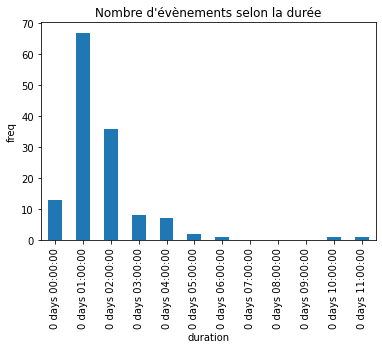

In [236]:
df_to_treat.reset_index()[df_to_treat["duration"].apply(lambda s:s >= dt.timedelta(days = 0) and s <= dt.timedelta(days = 1))].groupby(pd.Grouper(key="duration", freq='H'))['index'].count().plot(kind="bar", title="Nombre d'évènements selon la durée", ylabel="freq")

138


<AxesSubplot:title={'center':"Nombre d'évènements selon la durée"}, xlabel='duration', ylabel='freq'>

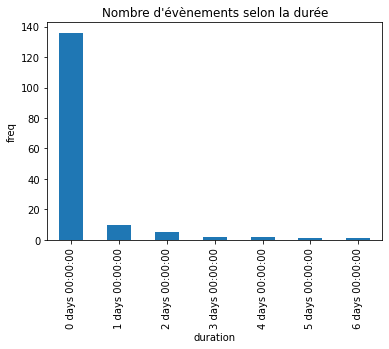

In [235]:
print(len(df_to_treat[df_to_treat["date_start"] == df_to_treat["date_end"]]))
df_to_treat.reset_index()[df_to_treat["duration"].apply(lambda s:s >= dt.timedelta(days = 0) and s <= dt.timedelta(days = 7))].groupby(pd.Grouper(key="duration", freq='D'))['index'].count().plot(kind="bar", title="Nombre d'évènements selon la durée", ylabel="freq")

On remarque que la grande majorité des évènements sont courts (la plupart ne durent même pas un jour).

### Prix

50


<AxesSubplot:title={'center':"Nombre d'évènements selon le prix"}, ylabel='Frequency'>

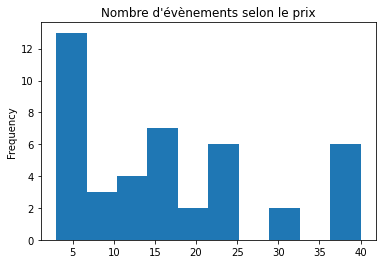

In [238]:
print(len(df_to_treat[df_to_treat['pricing_info'].notna()]))
df_to_treat[df_to_treat['pricing_info'].astype(float).apply(lambda s:s < 100)]['pricing_info'].plot(kind="hist",title="Nombre d'évènements selon le prix")

<AxesSubplot:title={'center':"Nombre d'évènements selon le prix (version très cher)"}, ylabel='Frequency'>

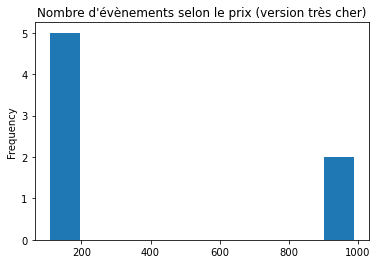

In [239]:
df_to_treat[df_to_treat['pricing_info'].astype(float).apply(lambda s:s > 100)]['pricing_info'].plot(kind="hist",title="Nombre d'évènements selon le prix (version très cher)")

On remarque qu'assez peu d'évènements ont un prix bien défini. Cela peut venir des problèmes venant des expressions régulières ou du nombre d'évènements à entrée libre. Notez qu'on pourrait appliquer notre raisonnement sur les tags à la colonne pricing_info. Ainsi les termes entrée libre, réservation ressortiraient sans doute et on pourrait créer une colonne à part entière.

Sinon la majorité des évènements restent inférieures à 50€. Quelques évènements semblent être bien supérieures même si on ne peut pas exclure une anomalie due au code.

### Distance

<AxesSubplot:title={'center':"Nombre d'évènements en fonction de la distance (depuis l'ENSAE)"}, ylabel='Frequency'>

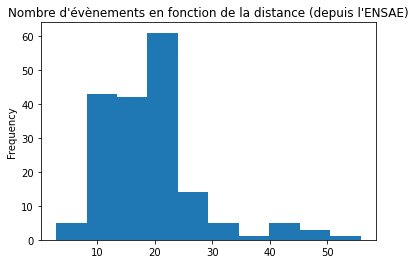

In [240]:
df_to_treat['distance'].plot(kind="hist",title="Nombre d'évènements en fonction de la distance (depuis l'ENSAE)")

<AxesSubplot:title={'center':"Nombre d'évènements en fonction de la distance (depuis le Louvre)"}, ylabel='Frequency'>

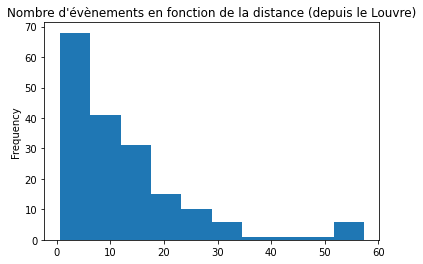

In [241]:
geolocator = Nominatim(user_agent="CulturalEvents")
location = geolocator.geocode("Rue de Rivoli, 75001 Paris")
df['latlon'].apply(lambda x: distance.distance(x, (location.latitude, location.longitude)).km).plot(kind="hist",title="Nombre d'évènements en fonction de la distance (depuis le Louvre)")

On remarque sans surprise que la distance qui nous sépare des évènements est bien plus élevé dans le centre de Paris que vers l'ENSAE où il faut faire 10km avant de trouver la plupart des évènements. On peut essayer de confirmer cela plus précisément avec une jointure spatiale sur une carte d'île de France.

In [181]:
df_to_treat['longitude'] = df_to_treat['geometry.coordinates'].apply(lambda s:s[0])
df_to_treat['latitude'] = df_to_treat['geometry.coordinates'].apply(lambda s:s[1])

geometry = [Point(xy) for xy in zip(df_to_treat['longitude'], df_to_treat['latitude'])]
gdf = gdp.GeoDataFrame(df_to_treat, crs="EPSG:4326", geometry=geometry)

In [27]:
départements = gdp.read_file("http://osm13.openstreetmap.fr/~cquest/openfla/export/departements-20180101-shp.zip", compression="zip")
départements

,code_insee,nom,nuts3,wikipedia,surf_km2,geometry
0,974,La Réunion,FR940,fr:La Réunion,2505.0,"MULTIPOLYGON (((55.21643 -21.03904, 55.21652 -..."
1,11,Aude,FR811,fr:Aude (département),6343.0,"POLYGON ((1.68872 43.27368, 1.69001 43.27423, ..."
2,43,Haute-Loire,FR723,fr:Haute-Loire,5003.0,"POLYGON ((3.08206 45.28988, 3.08209 45.29031, ..."
3,13,Bouches-du-Rhône,FR823,fr:Bouches-du-Rhône,5247.0,"MULTIPOLYGON (((4.23014 43.46047, 4.23025 43.4..."
4,47,Lot-et-Garonne,FR614,fr:Lot-et-Garonne,5385.0,"POLYGON ((-0.14058 44.22648, -0.12931 44.23218..."
...,...,...,...,...,...,...
97,56,Morbihan,FR524,fr:Morbihan,6870.0,"MULTIPOLYGON (((-3.73508 48.11140, -3.73507 48..."
98,25,Doubs,FR431,fr:Doubs (département),5256.0,"POLYGON ((5.69876 47.26464, 5.69877 47.26481, ..."
99,39,Jura,FR432,fr:Jura (département),5049.0,"MULTIPOLYGON (((5.25202 46.94451, 5.25208 46.9..."
100,07,Ardèche,FR712,fr:Ardèche (département),5566.0,"POLYGON ((3.86110 44.71118, 3.86110 44.71151, ..."


In [28]:
idf = départements[départements["code_insee"].apply(lambda s: s.startswith('75') or s.startswith('91') or s.startswith('92') or s.startswith('93') or s.startswith('94') or s.startswith('95') or s.startswith('77') or s.startswith('78'))]
idf

,code_insee,nom,nuts3,wikipedia,surf_km2,geometry
8,91,Essonne,FR104,fr:Essonne (département),1819.0,"POLYGON ((1.91446 48.46186, 1.91557 48.46495, ..."
34,75,Paris,FR101,fr:Paris,105.0,"POLYGON ((2.22412 48.85420, 2.22416 48.85462, ..."
35,92,Hauts-de-Seine,FR105,fr:Hauts-de-Seine,175.0,"POLYGON ((2.14565 48.83944, 2.14582 48.84080, ..."
47,77,Seine-et-Marne,FR102,fr:Seine-et-Marne,5927.0,"POLYGON ((2.39233 48.33593, 2.39300 48.33629, ..."
60,93,Seine-Saint-Denis,FR106,fr:Seine-Saint-Denis,236.0,"POLYGON ((2.28828 48.95840, 2.28834 48.95848, ..."
61,94,Val-de-Marne,FR107,fr:Val-de-Marne,244.0,"POLYGON ((2.30866 48.75542, 2.31026 48.75704, ..."
67,95,Val-d'Oise,FR108,fr:Val-d'Oise,1253.0,"POLYGON ((1.60900 49.07778, 1.60955 49.07783, ..."
73,78,Yvelines,FR103,fr:Yvelines,2306.0,"POLYGON ((1.44624 49.04639, 1.44945 49.04765, ..."


Pour donner une échelle, on trace des cercles qui représentent la distance  à partir de notre localisation. Notez qu'il faut convertir les kilomètres en degré pour la latitude et pour la longitude. 

1 km = 111.320*cos(degré latitude) degré pour la longitude et 1 km = 110.574 degré pour la latitude

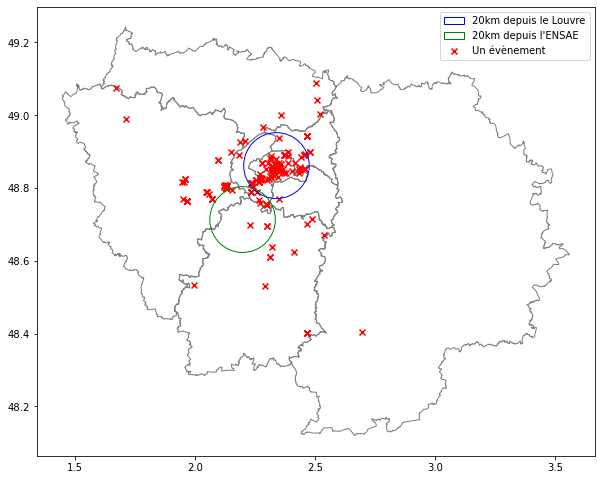

In [248]:
# Distance
km = Naclanga.distance_max

fig,ax = plt.subplots(figsize=(10, 10))

# From Paris
circle1 = Ellipse((location.longitude, location.latitude), width = km/(111.320*np.cos(location.latitude*np.pi/180)), height = km/110.574, color='b', fill=False)
ax.add_patch(circle1)

# From the ENSAE
location2 = Naclanga.latlon
circle2 = Ellipse((location2[1], location2[0]), width = km/(111.320*np.cos(location.latitude*np.pi/180)), height = km/110.574, color='g', fill=False)
ax.add_patch(circle2)

idf.plot(ax=ax, color='None', edgecolor='gray')
gdf.plot(ax=ax, marker='x', color='red')
plt.legend([str(km) +"km depuis le Louvre", str(km) +"km depuis l'ENSAE", "Un évènement"])

<AxesSubplot:>

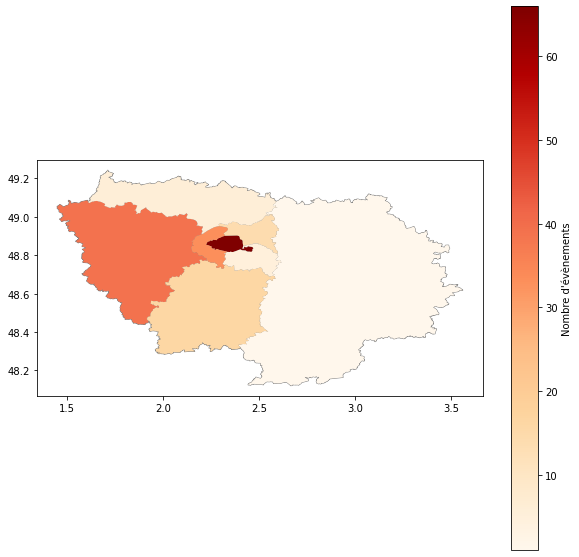

In [254]:
# Spatial joint
spatial_events = idf.sjoin(gdf, how="left")
spatial_events

# Regroup event by "départements"
spatial_events_groupby_dep = spatial_events.groupby("code_insee")
df_spatial_events = gdp.GeoDataFrame(geometry = spatial_events_groupby_dep["geometry"].first())
df_spatial_events["count"] = spatial_events_groupby_dep["nom"].count()
df_spatial_events

fig,ax = plt.subplots(figsize=(10, 10))
base = idf.plot(ax=ax, color='white', edgecolor='gray')
df_spatial_events.plot(ax=base, column="count", cmap='OrRd', legend=True, legend_kwds={'label': "Nombre d'évènements"})

Les deux derniers graphiques montrent bien la concentration d'évènement dans Paris mais aussi dans à l'Ouest et dans le Sud c'est à dire dans les Yvellines et l'Essonne. On peut expliquer le premier notamment par la présence de Versailles et en effet beaucoup d'évènements semblent se concentrer là bas sur le premier graphique. La popularité de l'évènementiel dans l'Essonne vient peut-être de sa population plus étudiante.

### Tags

In [256]:
def df_tags(df, tag, col = "tags"):
    ''' Returns a dataframe, all entries containt the tag in their tags '''
    return df[df[col].apply(lambda s: tag in s)]

L = []
for e in tags:
    L.append((e, len(df_tags(df_to_treat, e))))
L

[('musique', 20),
 ('atelier', 25),
 ('théâtre', 28),
 ('concert', 19),
 ('projet', 21),
 ('visite', 3),
 ('scène', 23),
 ('monde', 28),
 ('histoire', 26),
 ('année', 19),
 ('groupe', 5),
 ('samedi', 12),
 ('exposition', 12),
 ('jeu', 5),
 ('public', 10),
 ('enfant', 21),
 ('spectacle', 24),
 ('an', 38),
 ('place', 10),
 ('dimanche', 8),
 ('création', 12),
 ('rencontre', 14),
 ('conférence', 9),
 ('recherche', 14),
 ('association', 7),
 ('vie', 25),
 ('aide', 2),
 ('travers', 5),
 ('cadre', 11),
 ('découverte', 6),
 ('festival', 4),
 ('temps', 15),
 ('artiste', 15),
 ('maison', 8),
 ('formation', 8),
 ('œuvre', 8),
 ('danse', 12),
 ('siècle', 10),
 ('musée', 6),
 ('travail', 8),
 ('ville', 11),
 ('soirée', 3),
 ('journée', 3),
 ('heure', 13),
 ('université', 8),
 ('occasion', 10),
 ('programme', 9),
 ('chanson', 10),
 ('centre', 11),
 ('rue', 8)]

On peut par exemple essayer de trouver le tag le plus populaire dans chaque arrondissement

In [130]:
arrondissements = gdp.read_file("https://opendata.paris.fr/explore/dataset/arrondissements/download/?format=geojson&timezone=Europe/Berlin&lang=fr")
arrondissements

,c_ar,l_aroff,surface,l_ar,n_sq_co,c_arinsee,n_sq_ar,perimetre,geometry
0,1,Louvre,1.824613e+06,1er Ardt,750001537,75101,750000001,6054.936862,"POLYGON ((2.32801 48.86992, 2.32997 48.86851, ..."
1,7,Palais-Bourbon,4.090057e+06,7ème Ardt,750001537,75107,750000007,8099.424883,"POLYGON ((2.32090 48.86306, 2.32094 48.86305, ..."
2,8,Élysée,3.880036e+06,8ème Ardt,750001537,75108,750000008,7880.533268,"POLYGON ((2.32584 48.86956, 2.32569 48.86954, ..."
3,16,Passy,1.637254e+07,16ème Ardt,750001537,75116,750000016,17416.109657,"POLYGON ((2.27427 48.87837, 2.27749 48.87796, ..."
4,14,Observatoire,5.614877e+06,14ème Ardt,750001537,75114,750000014,10317.483310,"POLYGON ((2.33381 48.84061, 2.33673 48.83965, ..."
5,13,Gobelins,7.149311e+06,13ème Ardt,750001537,75113,750000013,11546.546526,"POLYGON ((2.37491 48.83801, 2.37698 48.83610, ..."
6,18,Buttes-Montmartre,5.996051e+06,18ème Ardt,750001537,75118,750000018,9916.464176,"POLYGON ((2.36580 48.88554, 2.36469 48.88437, ..."
7,12,Reuilly,1.631478e+07,12ème Ardt,750001537,75112,750000012,24089.666298,"POLYGON ((2.41388 48.83357, 2.41401 48.83357, ..."
8,11,Popincourt,3.665442e+06,11ème Ardt,750001537,75111,750000011,8282.011886,"POLYGON ((2.39624 48.85415, 2.39708 48.85308, ..."
9,15,Vaugirard,8.494994e+06,15ème Ardt,750001537,75115,750000015,13678.798315,"POLYGON ((2.29932 48.85217, 2.30088 48.85118, ..."


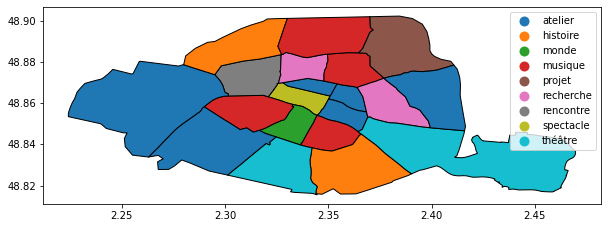

In [184]:
def tag_is_in(tag, L):
    ''' Returns 1 if the tag is in the list, 0 in the other case '''
    if tag in L:
        return 1
    else:
        return 0

def best_tag_by_ar(g):
    ''' Returns the best tag in the "arrondissement" '''
    
    # Spatial joint
    spatial_tags = arrondissements.sjoin(g, how="left")
    
    # We create a wide dataframe by developping the tags
    for e in tags:
        spatial_tags[e] = g["tags"].apply(lambda tags: tag_is_in(e, tags))

    # Regroup by "arrondissement"
    spatial_tags_groupby_ar = spatial_tags.groupby("c_ar")

    df_spatial_tags = gdp.GeoDataFrame(geometry = spatial_tags_groupby_ar["geometry"].first())
    
    # The column with the highest value is the most popular tag
    df_spatial_tags["tag"] = spatial_tags_groupby_ar[tags].sum().idxmax(axis=1, skipna=True)

    fig,ax = plt.subplots(figsize=(10, 10))
    base = df_spatial_tags.plot(ax=ax, column="tag", cmap='tab10', edgecolor='black', legend=True)

best_tab_by_ar(gdf)

Si l'on veut vraiment les tags les plus populaires à Paris, il vaut mieux faire appliquer cette fonction à la base de données entière. Cela implique de réappliquer les méthodes de NLP et la conversion en géopandas faites précédemment. Cela peut prendre un certain temps.

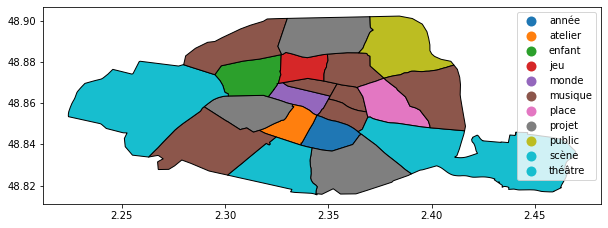

In [198]:
database_to_treat = database.head(10000).copy()

# Most important tags
database_to_treat['text'] = (NaN_to_String(database_to_treat['Description']) + NaN_to_String(database_to_treat['Détails']) + NaN_to_String(database_to_treat['Mots clés'])).apply(lambda s: s.replace(",", ", "))
database_to_treat['tags'] = database_to_treat['text'].apply(lambda x:return_POS(x.lower()))
database_to_treat['tags'] = database_to_treat['tags'].apply(lambda x: [k for k in x if k in tags])

# Conversion to geopandas
database_to_treat['latlon'] = database_to_treat['latlon'].apply(lambda s:s.split(","))
database_to_treat['longitude'] = database_to_treat['latlon'].apply(lambda s:float(s[0]))
database_to_treat['latitude'] = database_to_treat['latlon'].apply(lambda s:float(s[1]))
geometry = [Point(xy) for xy in zip(database_to_treat['longitude'], database_to_treat['latitude'])]
gdatabase = gdp.GeoDataFrame(database_to_treat, crs="EPSG:4326", geometry=geometry)

best_tag_by_ar(gdatabase)

### Carte finale

Finalement comme le prévoit notre projet à la base on va créer une carte dynamique en utilisant folium.

Tout d'abord il faut trouver les valeurs pour bien centrer / cadrer la carte.

In [257]:
location2 = Naclanga.latlon
center = [location2[0], location2[1]]

gdf['lat'] = gdf['latlon'].apply(lambda s:s[0])
gdf['lon'] = gdf['latlon'].apply(lambda s:s[1])

sw = gdf[['lat', 'lon']].min().values.tolist()
ne = gdf[['lat', 'lon']].max().values.tolist()

Ensuite on peut afficher les différents marqueurs. Voici la carte avec tous les évènements, on peut y voir le prix et les tags.

In [226]:
m = folium.Map(location = center, tiles='Stamen Toner')

folium.Marker(center, popup="You are here", icon=folium.Icon(color="red")).add_to(m)

for i in range(0,len(gdf)):        
    folium.Marker([gdf.iloc[i]['lat'], gdf.iloc[i]['lon']], popup=(gdf.iloc[i]['tags'], gdf.iloc[i]['pricing_info'])).add_to(m) 

m.fit_bounds([sw, ne])
m

On peut aussi restreindre le nombre d'évènements en diminuant le nombre de marqueurs

In [227]:
m = folium.Map(location = center, tiles='Stamen Toner')

Naclanga.distance_max = 20
Naclanga.price_max = 100
Naclanga.favourite_tag = "théâtre"

folium.Marker(center, popup="You are here", icon=folium.Icon(color="red")).add_to(m)

for i in range(0,len(gdf)):
    if gdf.iloc[i]['distance'] < Naclanga.distance_max and (gdf.iloc[i]['pricing_info'] < Naclanga.price_max or pd.isnull(gdf.iloc[i]['pricing_info'])) and Naclanga.favourite_tag in gdf.iloc[i]['tags']:
        folium.Marker([gdf.iloc[i]['lat'], gdf.iloc[i]['lon']], popup=(gdf.iloc[i]['tags'], gdf.iloc[i]['pricing_info'])).add_to(m) 

m.fit_bounds([sw, ne])
m

## Conclusion

Notre programme pourrait alors être adapté pour créer un véritable logiciel pour qu'on puisse changer les informations en dynamique sur la carte.